In [1]:
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from transformers import AutoTokenizer
from torch.optim import AdamW
from tqdm import tqdm
from einops import rearrange
from mambapy.mamba import MambaBlock, MambaConfig
from torch.utils.data import Dataset, DataLoader

/home/lad1chka/myenv1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Датасет
class PoetryDataset(Dataset):
    def __init__(self, filepath, tokenizer, max_length=64):
        self.df = pd.read_csv(filepath)
        self.tokenizer = tokenizer
        self.max_length = max_length
        
        # Фильтрация пустых строк
        self.df = self.df.dropna(subset=['text'])
        self.texts = self.df['text'].tolist()
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoded = self.tokenizer.encode_plus(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return encoded['input_ids'].squeeze(0)
  
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")
tokenizer.add_special_tokens({'pad_token': '[PAD]', 'eos_token': '</s>'})
dataset = PoetryDataset("/home/lad1chka/russianPoetryWithTheme.csv", tokenizer)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

In [3]:
# Модель
class PoetryMamba(nn.Module):
    def __init__(self, vocab_size, d_model=128, n_layers=3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        
        self.config = MambaConfig(
            d_model=d_model,
            d_state=8,
            d_conv=3,
            n_layers=n_layers
        )
        
        self.mamba_layers = nn.ModuleList([MambaBlock(self.config) for _ in range(n_layers)])
        
        self.attention = nn.MultiheadAttention(d_model, num_heads=4)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        
        self.head = nn.Linear(d_model, vocab_size)
        
        self.cache = None
        self.cache_size = 64
        
    def forward(self, x):
        x = self.embedding(x)
        
        for layer in self.mamba_layers:
            x = layer(x)
        
        attn_output, _ = self.attention(x, x, x)
        x = self.norm1(x + attn_output)
        
        x = self.norm2(x)
        return self.head(x)
    
    def generate(self, tokenizer, prompt, max_length=50, temperature=0.7, device='cpu'):
        self.eval()
        input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)
        
        with torch.no_grad():
            for i in range(max_length):
                model_input = input_ids[:, -self.cache_size:] if self.cache_size else input_ids
                
                logits = self(model_input)
                
                logits = logits[:, -1, :] / temperature
                probs = F.softmax(logits, dim=-1)
                next_token = torch.multinomial(probs, num_samples=1)
                
                input_ids = torch.cat([input_ids, next_token], dim=-1)
                
                if next_token.item() == tokenizer.eos_token_id:
                    break
        
        return tokenizer.decode(input_ids[0], skip_special_tokens=True)


In [4]:
# Инициализация 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vocab_size = tokenizer.vocab_size + len(tokenizer.added_tokens_encoder)
model = PoetryMamba(vocab_size).to(device)
optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)

Epoch 1: 100%|████████████████████████████| 2087/2087 [1:22:01<00:00,  2.36s/it]


Epoch 1, Loss: 6.7632
Пример генерации: Белая береза, В лиа. Дляи, - Ошьвги, как га легко сад, Вчеь ветер, В норак шнуло, и мой отрад нам,мая небес других, И вубои


Epoch 2: 100%|████████████████████████████| 2087/2087 [1:20:55<00:00,  2.33s/it]


Epoch 2, Loss: 5.6782
Пример генерации: Белая береза, гроза, ведь разклинежов, День в огнее узенья, Благ, снег каждый и ублю И весет, Но в где не встречатьяю,


Epoch 3: 100%|████████████████████████████| 2087/2087 [1:21:07<00:00,  2.33s/it]


Epoch 3, Loss: 5.3073
Пример генерации: Белая береза не уж золодный, Стоят в кох. Столем, не с ним весной, Направчки, Муженно, Дружешь, как, - Забысь не чем? -


Epoch 4: 100%|████████████████████████████| 2087/2087 [1:20:52<00:00,  2.33s/it]


Epoch 4, Loss: 5.0912
Пример генерации: Белая береза! Но мы прочь, - Как вдали охожу... Я не пропомрем, сопаца нас на вдали, И я я я другу, и в печали, А, что в медвое


Epoch 5: 100%|████████████████████████████| 2087/2087 [1:20:38<00:00,  2.32s/it]


Epoch 5, Loss: 4.9445
Пример генерации: Белая береза моя моих, Разнает над ложком, В страстей и грудь, - Ни, голубой, не - то правю, и встаю : « Я внимаю крылья


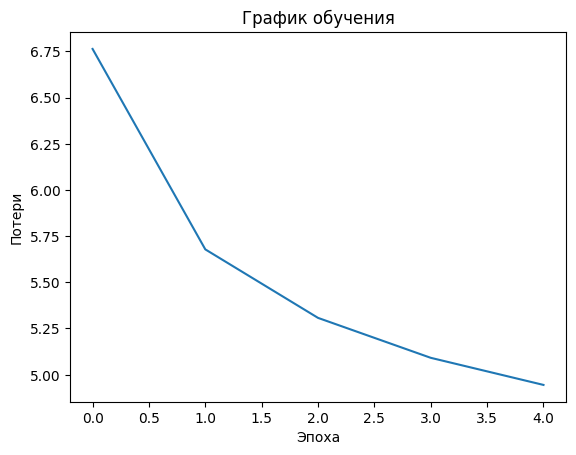

Сгенерированный стих:
Белая береза подых люблю, Исчет невольно. И я пройду только слезы, И взгляди, когда - то я в сном. Вот! - как ветрени, И они не надо Всею, крас И милой - Так - Все. Я с в не,ю
Модель сохранена в poetry_mamba_model.pth


In [5]:
# Обучение
epochs = 5

def train(model, dataloader, epochs):
    model.train()
    losses = []
    
    for epoch in range(epochs):
        epoch_loss = 0
        for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}"):
            input_ids = batch.to(device)
            optimizer.zero_grad()
            inputs = input_ids[:, :-1]
            targets = input_ids[:, 1:]
            logits = model(inputs)
            loss = criterion(logits.transpose(1, 2), targets)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / len(dataloader)
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")
        
        # Тест генерации
        sample = model.generate(tokenizer, "Белая береза", device=device)
        print(f"Пример генерации: {sample}")
    
    return losses

loss_history = train(model, dataloader, epochs)

# Визуализация
plt.plot(loss_history)
plt.title('График обучения')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.show()

# Сгенерируем что-нибудь
generated_poem = model.generate(
    tokenizer,
    prompt="Белая береза",
    max_length=100,
    temperature=0.7,
    device=device
)

print("Сгенерированный стих:")
print(generated_poem)

torch.save(model.state_dict(), "poetry_mamba_model.pth")
print("Модель сохранена в poetry_mamba_model.pth")